In [9]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import math

# Some hyper-parameters
input_shape = [224, 224, 3]  # we will resize the input images to this shape
batch_size = 64 
num_epochs = 10
random_seed = 42  # seed for some random operation, for reproducibility

# **Preparing the Data**

In [10]:
import cifar_utils

In [11]:
cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes
num_classes = cifar_info.features['label'].num_classes

# Number of train/val images
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

# Steps per epoch
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

In [12]:
train_cifar_dataset = cifar_utils.get_dataset(phase='train', batch_size=batch_size, 
                                              num_epochs=num_epochs, shuffle=True,
                                              input_shape=input_shape, 
                                              return_batch_as_tuple=True,
                                              seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(phase='val', batch_size=batch_size, 
                                            num_epochs=num_epochs, shuffle=False,
                                            input_shape=input_shape, 
                                            return_batch_as_tuple=True, 
                                            seed=random_seed)

# **Reusing ResNet-50 from Keras App**

### **Instantiating the model**

In [13]:
resnet50 = tf.keras.applications.ResNet50(include_top=True, weights=None,
                                         input_shape=input_shape, 
                                         classes=num_classes)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### **Training the network**

In [14]:
from keras_custom_callbacks import SimpleLogCallback

# Defining a custom metrics 
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, 
                                                                      name='top5_acc')

metrics_to_print = {'loss': 'loss', 'v-loss': 'val_loss', 'acc': 'acc',
                  'v-acc': 'val_acc', 'top5-acc': 'top5_acc', 
                  'v-top5-acc': 'val_top5_acc'}

# Defining optimizer and callbacks for training
optimizer = tf.keras.optimizers.Adam()

model_dir = './models/resnet_keras_app'
model_file = 'weights_epoch{epoch:02d}_loss{val_loss:.2f}.h5'
callbacks = [tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(os.path.join(model_dir, model_file),
                                                save_best_only=True),
             SimpleLogCallback(metrics_to_print, num_epochs, 2)]

# Finally, compiling and training
loss = tf.keras.losses.SparseCategoricalCrossentropy()
resnet50.compile(loss=loss, metrics=[accuracy_metric, top5_accuracy_metric], 
                 optimizer=optimizer)

history = resnet50.fit(train_cifar_dataset, epochs=num_epochs, 
                       steps_per_epoch=train_steps_per_epoch, verbose=0,
                       validation_data=val_cifar_dataset, callbacks=callbacks,
                       validation_steps=val_steps_per_epoch)


Training: start


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch  1/10: loss = 3.5969; v-loss = 4.2718; acc = 0.1501; v-acc = 0.1204; top5-acc = 0.4019; v-top5-acc = 0.3340
Epoch  3/10: loss = 2.6611; v-loss = 48.0017; acc = 0.3212; v-acc = 0.0241; top5-acc = 0.6370; v-top5-acc = 0.1015
Epoch  5/10: loss = 2.1391; v-loss = 2.5060; acc = 0.4323; v-acc = 0.3885; top5-acc = 0.7477; v-top5-acc = 0.6764
Epoch  7/10: loss = 1.7213; v-loss = 2.0661; acc = 0.5275; v-acc = 0.4655; top5-acc = 0.8246; v-top5-acc = 0.7641


Epoch  9/10: loss = 1.4332; v-loss = 1.6444; acc = 0.5933; v-acc = 0.5529; top5-acc = 0.8728; v-top5-acc = 0.8362
Training: end


Draw some training and validation trends:

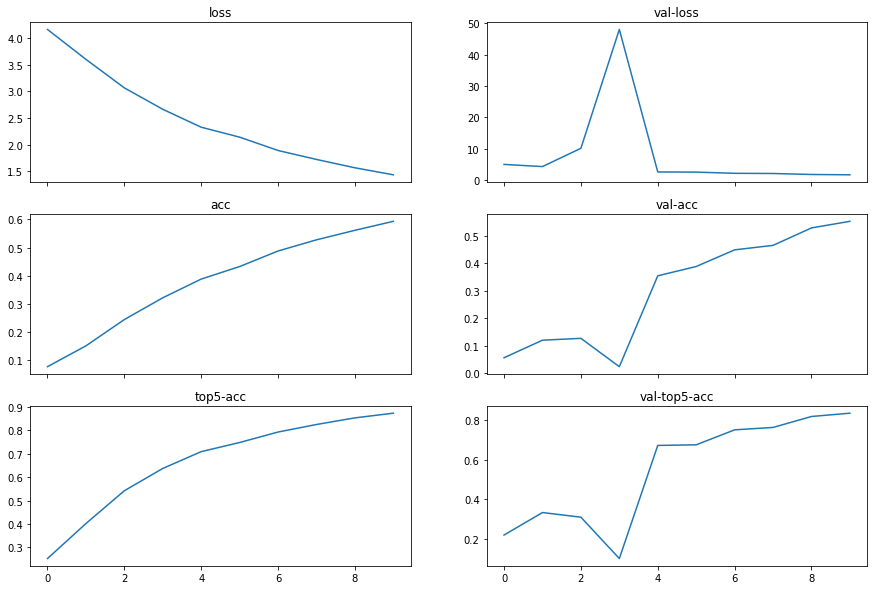

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex='col')
axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('acc')
axs[1, 1].set_title('val-acc')
axs[2, 0].set_title('top5-acc')
axs[2, 1].set_title('val-top5-acc')

axs[0, 0].plot(history.history['loss'])
axs[0, 1].plot(history.history['val_loss'])
axs[1, 0].plot(history.history['acc'])
axs[1, 1].plot(history.history['val_acc'])
axs[2, 0].plot(history.history['top5_acc'])
axs[2, 1].plot(history.history['val_top5_acc'])

In [16]:
best_val_acc = max(history.history['val_acc']) * 100
best_val_top5 = max(history.history['val_top5_acc']) * 100

print('Best val acc: {:.2f}%'.format(best_val_acc))
print('Best val top5: {:.2f}%'.format(best_val_top5))

Best val acc: 55.29%
Best val top5: 83.62%


### **Predicting with the Network**

Test image shape: (16, 224, 224, 3)


/content/classification_utils.py:87: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()  # `tight_layout()` similar to `constrained_layout = True`


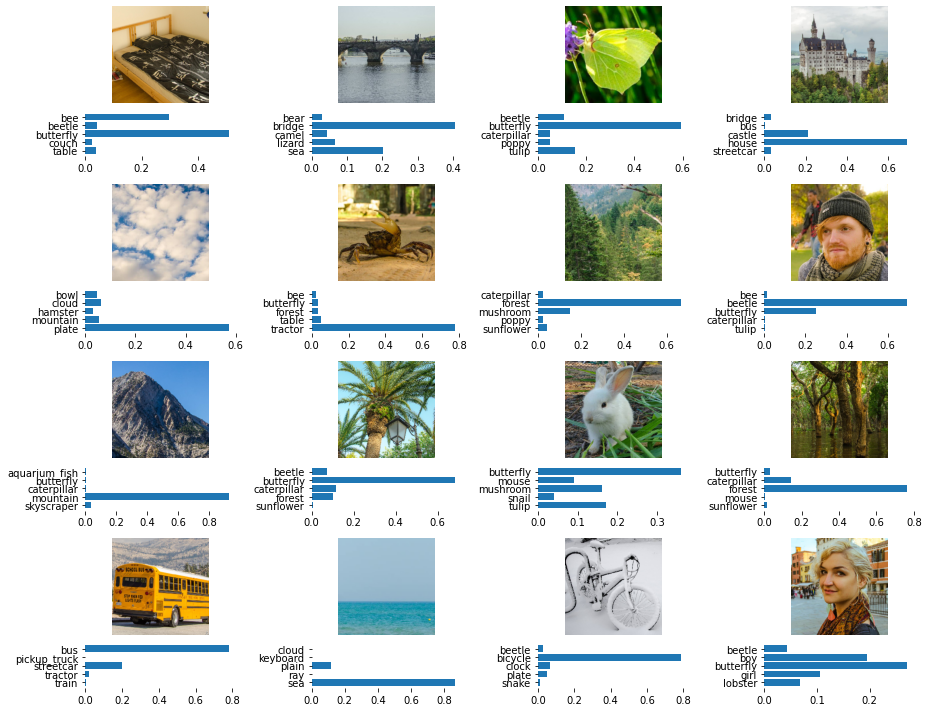

In [20]:
import numpy as np
from classification_utils import load_image, process_predictions, display_predictions
import glob

test_img_dir = 'drive/MyDrive/res'
# Get all test filenames then convert to np.array
test_filenames = glob.glob(os.path.join(test_img_dir, '*'))
test_imgs = np.asarray([load_image(filename, input_shape[:-1]) for filename in test_filenames])
print('Test image shape: {}'.format(test_imgs.shape))

img_batch = test_imgs[:16]

# Our model was trained on CIFAR images, which originally are 32x32px. We scaled
# them up to 224x224px to train our model on, but this means the resulting images 
# had important artifacts/low quality.
# To test on images of the same quality, we first resize them to 32x32px, then to the 
# expected input size (i.e., 224x224px):
cifar_img_original_size = cifar_info.features['image'].shape[:-1]
test_batch_low_quality = tf.image.resize(img_batch, cifar_img_original_size)
test_batch_low_quality = tf.image.resize(test_batch_low_quality,
                                               input_shape[:-1])

# Predicting test batch by our model
predictions = resnet50.predict_on_batch(test_batch_low_quality)

class_readable_labels = cifar_info.features['label'].names

top5_labels, top5_probabilities = process_predictions(predictions,
                                                      class_readable_labels,
                                                      5)

display_predictions(img_batch, top5_labels, top5_probabilities)

